In [1]:
import implicit
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

In [3]:
# функция, которая красиво печатает информацию о разреженных матрицах
from scipy.sparse import csr_matrix

def sparse_info(sparse_matrix: csr_matrix) -> None:
    print("Размерности матрицы: {}".format(sparse_matrix.shape))
    print("Ненулевых элементов в матрице: {}".format(sparse_matrix.nnz))
    print("Доля ненулевых элементов: {}"
          .format(sparse_matrix.nnz / sparse_matrix.shape[0] / sparse_matrix.shape[1])
    )
    print("Среднее значение ненулевых элементов: {}".format(sparse_matrix.data.mean()))
    print("Максимальное значение ненулевых элементов: {}".format(sparse_matrix.data.max()))
    print("Минимальное значение ненулевых элементов: {}".format(sparse_matrix.data.min()))

In [4]:
col_names = ["user", "artist_mbid", "artist_name", "total_plays"]

In [5]:
data = pd.read_csv("lastfm_small.tsv", sep="\t",header=None,names=col_names)
data.head()

,user,artist_mbid,artist_name,total_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
user           1000000 non-null object
artist_mbid    987168 non-null object
artist_name    1000000 non-null object
total_plays    1000000 non-null int64
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [7]:
data[data.artist_mbid.isnull() == True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12832 entries, 158 to 999966
Data columns (total 4 columns):
user           12832 non-null object
artist_mbid    0 non-null object
artist_name    12832 non-null object
total_plays    12832 non-null int64
dtypes: int64(1), object(3)
memory usage: 501.2+ KB


In [8]:
data.dropna( axis=0, how = 'any', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987168 entries, 0 to 999999
Data columns (total 4 columns):
user           987168 non-null object
artist_mbid    987168 non-null object
artist_name    987168 non-null object
total_plays    987168 non-null int64
dtypes: int64(1), object(3)
memory usage: 37.7+ MB


In [9]:
# заменим строковые идентификаторы числовыми кодами
# добавляем к индексам единицы, потому что в mrec,
# который будем использовать для оценки качества, индексы начинаются с единицы
data["user_id"] = data["user"].astype("category").cat.codes.copy()+1
data["artist_id"] = data["artist_mbid"].astype("category").cat.codes.copy() + 1

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987168 entries, 0 to 999999
Data columns (total 6 columns):
user           987168 non-null object
artist_mbid    987168 non-null object
artist_name    987168 non-null object
total_plays    987168 non-null int64
user_id        987168 non-null int16
artist_id      987168 non-null int32
dtypes: int16(1), int32(1), int64(1), object(3)
memory usage: 43.3+ MB


In [11]:
data.describe()

,total_plays,user_id,artist_id
count,987168.000000,987168.000000,987168.000000
mean,217.479664,10232.484131,33572.788481
std,606.759652,5911.779514,19332.163691
min,1.000000,1.000000,1.000000
25%,34.000000,5117.000000,17049.000000
50%,95.000000,10237.000000,34352.000000
75%,225.000000,15347.000000,49720.000000
max,135392.000000,20462.000000,66798.000000


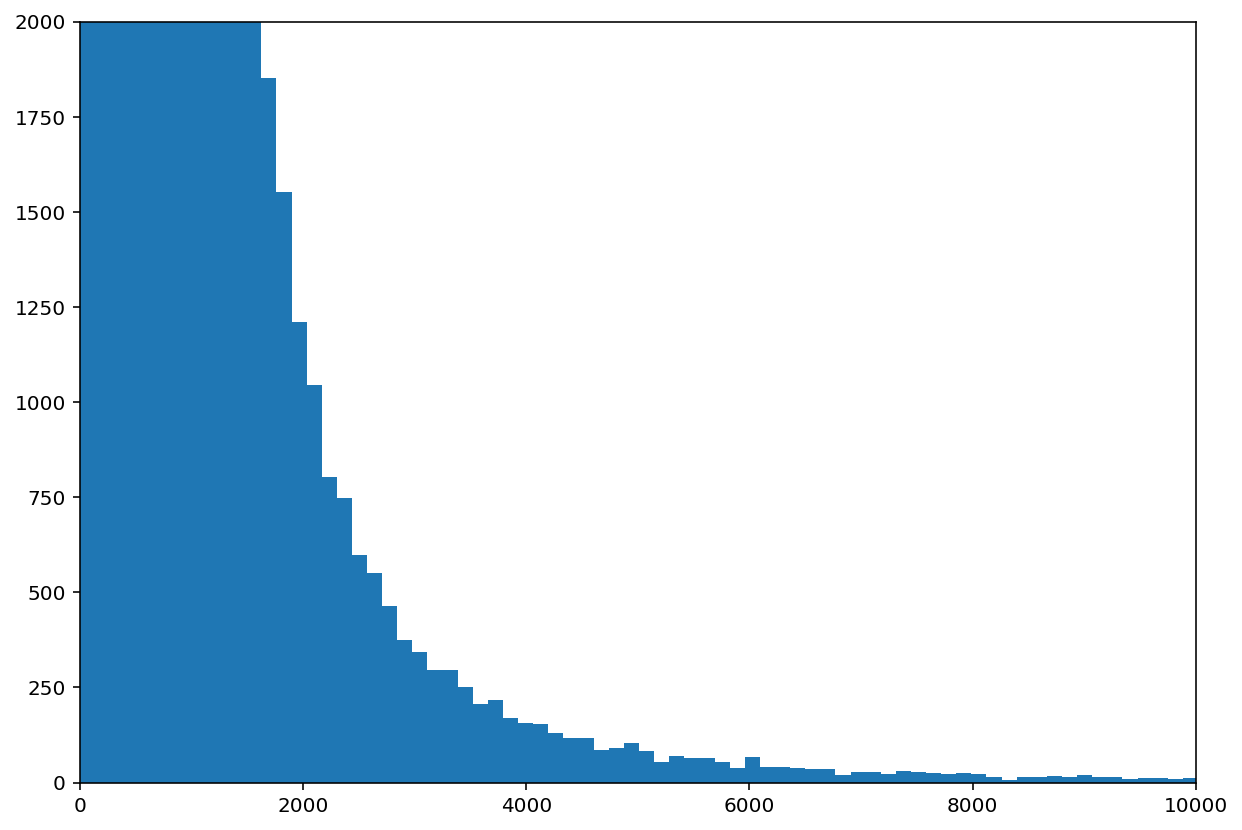

In [58]:
#рассмотрим, где сконцентрировано основное число прослушиваний
plt.hist(data['total_plays'], bins = 1000)
plt.xlim(-1, 10000)
plt.ylim(0, 2000);

In [13]:
#выберем адекватное число прослушиваний треков
lf = data[data['total_plays'] <= 10000]

In [14]:
lf.reset_index(inplace = True)

In [15]:
del lf['index']

In [16]:
lf.describe()

,total_plays,user_id,artist_id
count,986823.000000,986823.000000,986823.000000
mean,211.188941,10232.261884,33573.295234
std,418.376216,5911.744094,19332.305450
min,1.000000,1.000000,1.000000
25%,34.000000,5117.000000,17049.000000
50%,95.000000,10237.000000,34352.000000
75%,225.000000,15346.000000,49720.000000
max,9991.000000,20462.000000,66798.000000


In [ ]:
#lf = data

In [17]:
# разобьём наблюдения на тестовую и обучающую выборки
test_indices = np.random.choice(
    lf.index.values,
    replace=False,
    size=int(len(lf.index.values) * 0.3)
)
lf_test = lf.iloc[test_indices]
lf_train = lf.drop(test_indices)

In [18]:
test_user_set = set(lf_test["user_id"].unique())
train_user_set = set(lf_train["user_id"].unique())
print("нет в обучающей выборке, но есть в тестовой: {}".format(
    len(test_user_set - train_user_set)))
print("нет в тестовой выборке, но есть в обучающей: {}".format(
    len(train_user_set - test_user_set)))
print("всего пользователей: {}".format(len(data["user_id"].unique())))

нет в обучающей выборке, но есть в тестовой: 3
нет в тестовой выборке, но есть в обучающей: 11
всего пользователей: 20462


In [19]:
user_ids_to_exclude = (test_user_set - train_user_set).union(train_user_set - test_user_set)
bad_indices = lf_test[lf_test["user_id"].isin(user_ids_to_exclude).values].index
lf_test.drop(bad_indices, inplace=True)
bad_indices = lf_train[lf_train["user_id"].isin(user_ids_to_exclude).values]
lf_train.drop(bad_indices.index, inplace=True)

C:\Users\blacat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
test_file_name = "lastfm.test.0"
lf_test[["user_id", "artist_id", "total_plays"]].to_csv(test_file_name, sep="\t", header=False,index=False)
train_file_name = "lastfm.train.0"
lf_train[["user_id", "artist_id", "total_plays"]].to_csv(train_file_name, sep="\t", header=False, index=False)

In [22]:
# создаём разреженную матрицу item*user
from scipy.sparse import coo_matrix

plays = coo_matrix((
     lf_train['total_plays'].astype(np.float),
    (
        lf_train["artist_id"],
        lf_train["user_id"]
    )
))

sparse_info(plays.tocsr())

Размерности матрицы: (66799, 20463)
Ненулевых элементов в матрице: 690730
Доля ненулевых элементов: 0.0005053229857717916
Среднее значение ненулевых элементов: 211.21343361371302
Максимальное значение ненулевых элементов: 9991.0
Минимальное значение ненулевых элементов: 1.0


# KNN

In [68]:
%%time
from implicit.nearest_neighbours import CosineRecommender

model = CosineRecommender(K=400)
model.fit(plays)
sparse_info(model.similarity)

Размерности матрицы: (66799, 66799)
Ненулевых элементов в матрице: 7226480
Доля ненулевых элементов: 0.0016195221159182754
Среднее значение ненулевых элементов: 0.09969025900969034
Максимальное значение ненулевых элементов: 1.0000000000000038
Минимальное значение ненулевых элементов: 0.0
Wall time: 4.65 s


In [69]:
%%time
print("получаем рекомендации для всех пользователей")
user_plays = plays.T.tocsr()
with open("lastfm.test.0.recs.tsv", "w") as output_file:
    for user_id in tqdm_notebook(lf_test["user_id"].unique()):
        for artist_id, score in model.recommend(user_id, user_plays, N = 10):
                output_file.write("%s\t%s\t%s\n" % (user_id, artist_id, score))

получаем рекомендации для всех пользователей


A Jupyter Widget


Wall time: 1min 52s


In [ ]:
# используем mrec в качестве метрики качества
!mrec_evaluate --input_format tsv --test_input_format tsv --train "c:/lfm/lastfm.train.*" --recsdir c:/lfm/recs

In [ ]:
!mrec_evaluate --help

# ALS

In [25]:
from implicit.als import AlternatingLeastSquares

In [55]:
als_model = AlternatingLeastSquares(factors=200,
                                regularization=0.001,
                                dtype=np.float,
                                iterations=150)


als_model.fit(plays)

In [56]:
%%time
print("получаем рекомендации для всех пользователей")
user_plays = plays.T.tocsr()
with open("alslfm.test.0.recs.tsv", "w") as output_file:
    for user_id in tqdm_notebook(lf_test["user_id"].unique()):
        for artist_id, score in als_model.recommend(user_id, user_plays, N = 10):
                output_file.write("%s\t%s\t%s\n" % (user_id, artist_id, score))

получаем рекомендации для всех пользователей


A Jupyter Widget


Wall time: 3min 17s


# AnnoyAlternatingLeastSquares

In [37]:
from implicit.approximate_als import AnnoyAlternatingLeastSquares

In [70]:
ann_model = AnnoyAlternatingLeastSquares(n_trees = 300)

In [71]:
%%time
ann_model.fit(plays)

Wall time: 3min 16s


In [72]:
%%time
print("получаем рекомендации для всех пользователей")
user_plays = plays.T.tocsr()
with open("annoylfm.test.0.recs.tsv", "w") as output_file:
    for user_id in tqdm_notebook(lf_test["user_id"].unique()):
        for artist_id, score in ann_model.recommend(user_id, user_plays, N = 10):
                output_file.write("%s\t%s\t%s\n" % (user_id, artist_id, score))

получаем рекомендации для всех пользователей


A Jupyter Widget


Wall time: 1min 7s
